In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from heapq import heappop, heappush
from random import randint
from datetime import datetime
%matplotlib inline

from src.grid import intersect_cells, Map, intersect_points
from src.theta import Node, theta, theta_multy_choose, make_path
from src.lazy_theta import lazy_theta
from src.theta_ap import theta_ap
from src.utils import *
from src.search_tree import *

In [2]:
def draw_intersect(width, height, i1, j1, i2, j2):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 50
    r = 0.05 * k
    rr = 0.15 * k
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    
    cells = intersect_cells(i1, j1, i2, j2)
    points = intersect_points(i1, j1, i2, j2)
    
    for cell in cells:
        i = cell[0]
        j = cell[1]
        draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(231, 76, 60))
        
        
    # grid points
    for i in range(height + 1):
        for j in range(width + 1):
            draw.ellipse((j * k - r, i * k - r, j * k + r, i * k + r), fill=(50, 50, 50))
            
            
    for point in points:
        i = point[0]
        j = point[1]
        draw.ellipse((j * k - rr, i * k - rr, j * k + rr, i * k + rr), fill=(131, 76, 60))
            
    draw.line((j1 * k, i1*k, j2 * k, i2 * k),  fill=( 70, 80, 80 ))
        

    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

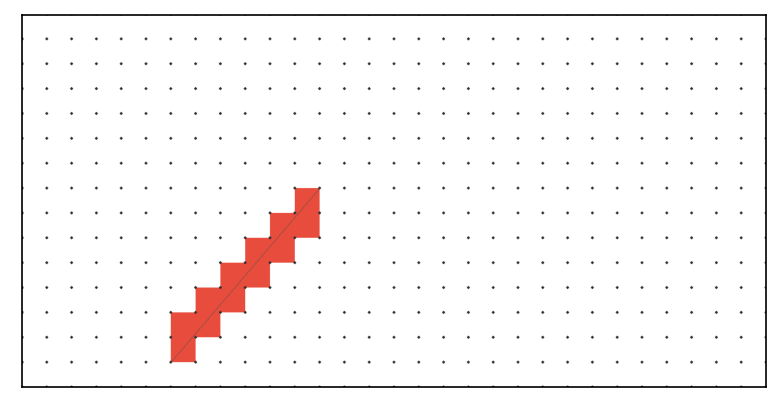

In [3]:
draw_intersect(30, 15, 14, 6, 7, 12)

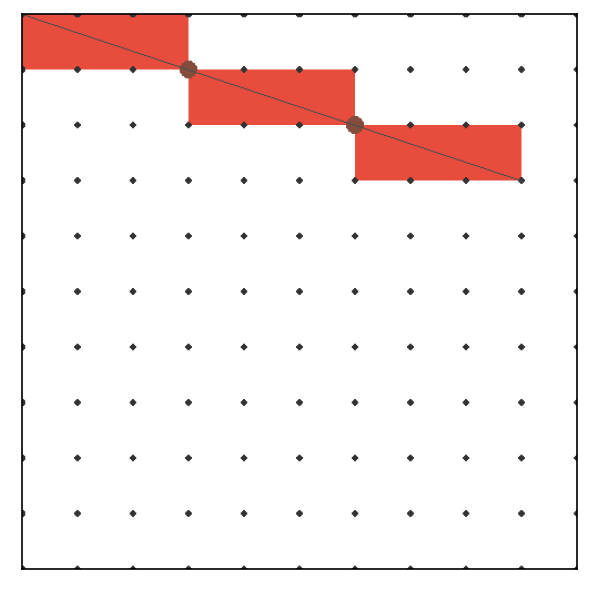

In [4]:
draw_intersect(10, 10, 0, 0, 3, 9)


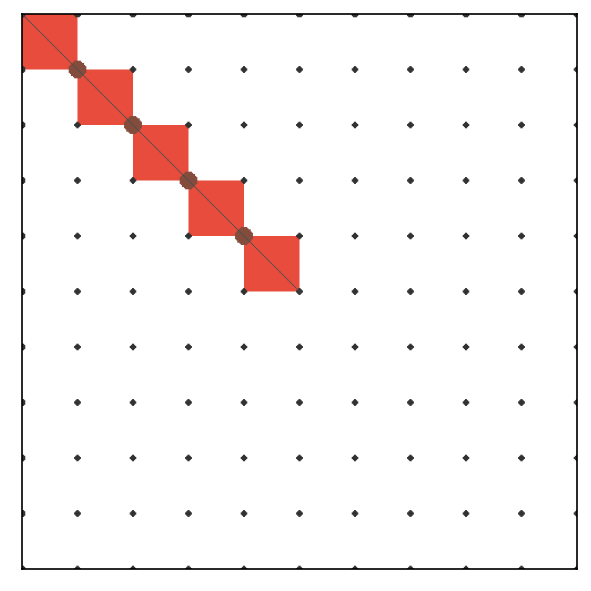

In [5]:
draw_intersect(10, 10, 0, 0, 5, 5)

In [6]:
def draw(grid_map, start = None, goal = None, path = None,
         nodes_opened = None, nodes_expanded = None, nodes_reexpanded = None):
    '''
    Auxiliary function that visualizes the environment, the path and 
    the open/expanded/re-expanded nodes.
    
    The function assumes that nodes_opened/nodes_expanded/nodes_reexpanded
    are iterable collestions of SearchNodes
    '''
    k = 15
    r = 0.3 * k
    height, width = grid_map.get_size()
    h_im = height * k
    w_im = width * k
    im = Image.new('RGB', (w_im, h_im), color = 'white')
    draw = ImageDraw.Draw(im)
    
    # grid points
    for i in range(height + 1):
        for j in range(width + 1):
            pass
#            draw.ellipse((j * k - r, i * k - r, j * k + r, i * k + r), fill=(50, 50, 50))
    
    # obstacles
    for i in range(height):
        for j in range(width):
            if(not grid_map.traversable(i, j)):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    # opened
    if nodes_opened is not None:
        for node in nodes_opened:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)
    
    # expanded
    if nodes_expanded is not None:
        for node in nodes_expanded:
            pass
#            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(131, 145, 146), width=0)
    
    # reexpanded
    if nodes_reexpanded is not None:
        for node in nodes_reexpanded:
            pass
#                draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(255, 145, 146), width=0)
    
    # path
    if path is not None:
        for step in path:
            draw.line(((step.j * k, step.i * k), (step.parent.j * k, step.parent.i * k)), fill=(219, 152, 52))
            draw.ellipse((step.j * k - r, step.i * k - r, step.j * k + r, step.i * k + r), fill=(52, 152, 219))
                

    if (start is not None) and (grid_map.traversable(start.i, start.j)):
        draw.ellipse((start.j * k - r, start.i * k - r, start.j * k + r, start.i * k + r), fill=(40, 180, 99))
    
    if (goal is not None) and (grid_map.traversable(goal.i, goal.j)):
        draw.ellipse((goal.j * k - r, goal.i * k - r, goal.j * k + r, goal.i * k + r), fill=(231, 76, 60))


    _, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))
    plt.show()

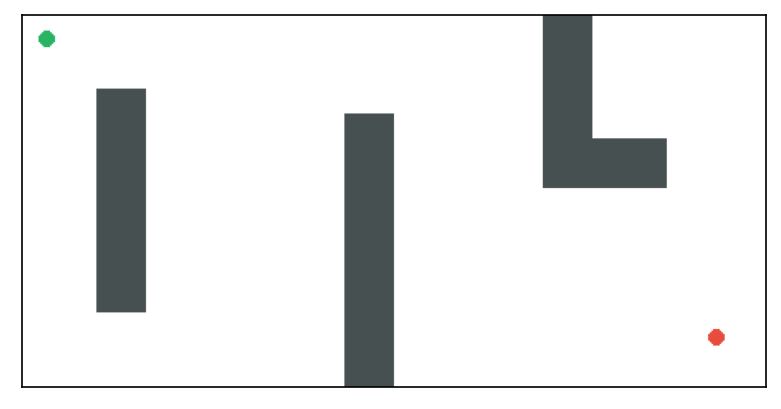

In [7]:
height = 15
width = 30
map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

test_map = Map()
test_map.read_from_string(map_str, width, height)
start = Node(1, 1)
goal = Node(13, 28)
draw(test_map, start, goal)

In [8]:
def simple_test(search_func, task, *args, **kwargs):
    '''
    simple_test runs search_func on one task (use a number from 0 to 25 to choose a certain debug task on simple map or None to choose a random task from this pool) with *args as optional arguments and displays:
     - 'Path found!' and some statistics -- path was found
     - 'Path not found!' -- path was not found
     - 'Execution error' -- an error occurred while executing the SearchFunction In first two cases function also draws visualisation of the task
    '''
    
    height = 15
    width = 30
    map_str = '''
.....................@@.......
.....................@@.......
.....................@@.......
...@@................@@.......
...@@........@@......@@.......
...@@........@@......@@@@@....
...@@........@@......@@@@@....
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
...@@........@@...............
.............@@...............
.............@@...............
.............@@...............
'''

    task_map = Map()
    task_map.read_from_string(map_str, width, height)
    starts = [(9, 0), (13, 0), (7, 28), (14, 29), (4, 1), (0, 17), (5, 6), (5, 20), (12, 2), (7, 28), (11, 9), (3, 2), (3, 17), (13, 20), (1, 1), (9, 10), (14, 6), (2, 0), (9, 28), (8, 6), (11, 6), (3, 0), (8, 9), (14, 7), (12, 4), (7, 1), (9, 2), (3, 5), (3, 5)]
    goals = [(11, 20), (2, 19), (6, 5), (4, 18), (9, 20), (7, 0), (2, 25), (12, 4), (3, 25), (0, 12), (4, 23), (2, 24), (9, 2), (1, 6), (13, 29), (14, 29), (2, 28), (14, 16), (13, 0), (1, 27), (14, 25), (10, 20), (12, 28), (2, 29), (1, 29), (4, 26), (3, 17), (9, 2), (3, 5)]

    if (task is None) or not (0 <= task < len(starts)):
        task = randint(0, len(starts) - 1)
        
    print("task number: ", task)

    start = Node(*starts[task])
    goal = Node(*goals[task])
    try:
        result = search_func(task_map, start.i, start.j, goal.i, goal.j, *args, **kwargs)
        number_of_steps = result[2].expansions
        nodes_created = result[2].max_tree_size
        if result[0]:
            path = make_path(result[1])
            print("Path found! Length: " + str(result[2].way_length) + \
                ". Memory_usage: " + str(nodes_created) + \
                ". Number of steps: " + str(number_of_steps))
            path_cells = [(node.i, node.j) for node in path[0]]
            print(path_cells)
            draw(task_map, start, goal, path[0], *result[3:])
        else:
            print("Path not found!")
        return result

    except Exception as e:
        print("Execution error")
        print(e)


In [9]:
%time res = simple_test(theta, 6, euclidian_distance, SearchTreePQS, w = 2)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 295 µs, sys: 276 µs, total: 571 µs
Wall time: 191 µs


In [10]:
%time res = simple_test(theta_ap, 6, theta_heuristic, SearchTreePQS)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 292 µs, sys: 272 µs, total: 564 µs
Wall time: 189 µs


In [11]:
%time res = simple_test(theta, 6, euclidian_distance, SearchTreePQS, w = 1, k = 8)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 0 ns, sys: 647 µs, total: 647 µs
Wall time: 213 µs


In [12]:
%time res = simple_test(theta_multy_choose, 6, theta_heuristic, SearchTreePQS, w = 1)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 401 µs, sys: 375 µs, total: 776 µs
Wall time: 260 µs


In [13]:
%time res = simple_test(theta, 6, theta_heuristic, SearchTreePQSReexp, w = 1, k = 8)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 308 µs, sys: 287 µs, total: 595 µs
Wall time: 199 µs


task number:  28
Path found! Length: 0. Memory_usage: 0. Number of steps: 0
[(3, 5)]


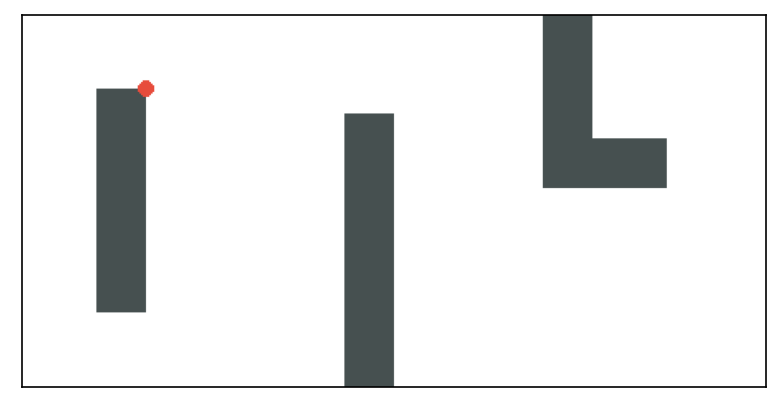

CPU times: user 79.5 ms, sys: 99.4 ms, total: 179 ms
Wall time: 59.5 ms


In [14]:
%time res = simple_test(theta, 28, theta_heuristic, SearchTreePQSReexp, w = 1, k = 8)

In [15]:
%time res = simple_test(lazy_theta, 6, theta_heuristic, SearchTreePQSReexp, w = 1, k = 8)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 0 ns, sys: 1.66 ms, total: 1.66 ms
Wall time: 548 µs


In [16]:
%time res = simple_test(theta_ap, 6, euclidian_distance, SearchTreePQS)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 920 µs, sys: 870 µs, total: 1.79 ms
Wall time: 559 µs


In [17]:
%time res = simple_test(theta_ap, 6, theta_heuristic, SearchTreePQS)

task number:  6
Execution error
list indices must be integers or slices, not float
CPU times: user 345 µs, sys: 328 µs, total: 673 µs
Wall time: 225 µs
